 # Predicting movie's IMDB rating

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from random import randrange


  ## Import and process CSV
  * Remove row which contain empty cell
  * Reset Index for easier preprocessing step

In [2]:
url = ('./src/IMDB-Movie-Data.csv')
csv = pd.read_csv(url, sep=",")
csv = csv.dropna(axis="index", how="any")
csv = csv.sort_values(by=["Rating"], ascending=False)
csv = csv.reset_index(drop=True)
csv.head()


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,55,The Dark Knight,"Action,Crime,Drama",When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart,Mi...",2008,152,9.0,1791916,533.32,82.0
1,81,Inception,"Action,Adventure,Sci-Fi","A thief, who steals corporate secrets through ...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",2010,148,8.8,1583625,292.57,74.0
2,37,Interstellar,"Adventure,Drama,Sci-Fi",A team of explorers travel through a wormhole ...,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,8.6,1047747,187.99,74.0
3,250,The Intouchables,"Biography,Comedy,Drama",After he becomes a quadriplegic from a paragli...,Olivier Nakache,"François Cluzet, Omar Sy, Anne Le Ny, Audrey F...",2011,112,8.6,557965,13.18,57.0
4,97,Kimi no na wa,"Animation,Drama,Fantasy",Two strangers find themselves linked in a biza...,Makoto Shinkai,"Ryûnosuke Kamiki, Mone Kamishiraishi, Ryô Nari...",2016,106,8.6,34110,4.68,79.0


  ## Feature & target selection
  * Select relevant feature (excluding XYZ)
  * Feature "Description" was removed because NLP (Natural Language Processing) isn't used
  * Feature "Metascore" was selected because Metascore usually comes out before movie release
  * On data pre-processing step we will remove some feature

In [3]:
x = csv[["Genre", "Director", "Actors",
         "Runtime (Minutes)", "Revenue (Millions)", "Votes", "Metascore", "Year"]]
y = csv["Rating"]

x.head()


,Genre,Director,Actors,Runtime (Minutes),Revenue (Millions),Votes,Metascore,Year
0,"Action,Crime,Drama",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart,Mi...",152,533.32,1791916,82.0,2008
1,"Action,Adventure,Sci-Fi",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",148,292.57,1583625,74.0,2010
2,"Adventure,Drama,Sci-Fi",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",169,187.99,1047747,74.0,2014
3,"Biography,Comedy,Drama",Olivier Nakache,"François Cluzet, Omar Sy, Anne Le Ny, Audrey F...",112,13.18,557965,57.0,2011
4,"Animation,Drama,Fantasy",Makoto Shinkai,"Ryûnosuke Kamiki, Mone Kamishiraishi, Ryô Nari...",106,4.68,34110,79.0,2016


  ## Data pre-processing #1
  * Convert feature "Genre" & "Actors" data type from string to list because a movie could have more than a genre and an actor
  * Change feature "Year" into movie age (since release year)
  * Rename column for convenience sake

In [4]:
list_genre = []
for i in range(0, x["Genre"].size):
    list_genre.append(x["Genre"][i].split(','))
x["Genre"].update(pd.Series(list_genre))

list_actors = []
for i in range(0, x["Actors"].size):
    list_actors.append(x["Actors"][i].split(','))
x["Actors"].update(pd.Series(list_actors))

# Column position, column name, column value
x.insert(3, "Age", [2019] - x["Year"])
x = x.rename(columns={"Revenue (Millions)": "Revenue"})
x = x.rename(columns={"Runtime (Minutes)": "Runtime"})
x = x.drop(columns=["Year"])

x.head()


,Genre,Director,Actors,Age,Runtime,Revenue,Votes,Metascore
0,"[Action, Crime, Drama]",Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart...",11,152,533.32,1791916,82.0
1,"[Action, Adventure, Sci-Fi]",Christopher Nolan,"[Leonardo DiCaprio, Joseph Gordon-Levitt, El...",9,148,292.57,1583625,74.0
2,"[Adventure, Drama, Sci-Fi]",Christopher Nolan,"[Matthew McConaughey, Anne Hathaway, Jessica...",5,169,187.99,1047747,74.0
3,"[Biography, Comedy, Drama]",Olivier Nakache,"[François Cluzet, Omar Sy, Anne Le Ny, Audr...",8,112,13.18,557965,57.0
4,"[Animation, Drama, Fantasy]",Makoto Shinkai,"[Ryûnosuke Kamiki, Mone Kamishiraishi, Ryô N...",3,106,4.68,34110,79.0


  ## Data pre-processing #2
  Perform normalization to all features which uses number/decimal. Normalization usually have range -1 to -1 or 0 to 1.

In [5]:
ndarray_runtime = np.array(x["Runtime"])
ndarray_metascore = np.array(x["Metascore"])
ndarray_age = np.array(x["Age"])
ndarray_votes = np.array(x["Votes"])
ndarray_revenue = np.array(x["Revenue"])

interp_runtime = np.interp(
    ndarray_runtime, (0, ndarray_runtime.max()), (0, +3))
interp_metascore = np.interp(
    ndarray_metascore, (0, ndarray_metascore.max()), (0, +5))
interp_age = np.interp(ndarray_age, (0, ndarray_age.max()), (0, +1))
interp_votes = np.interp(ndarray_votes, (0, ndarray_votes.max()), (0, +4))
interp_revenue = np.interp(
    ndarray_revenue, (0, ndarray_revenue.max()), (0, +1))

x["Runtime"].update(pd.Series(interp_runtime))
x["Metascore"].update(pd.Series(interp_metascore))
x["Age"].update(pd.Series(interp_age))
x["Votes"].update(pd.Series(interp_votes))
x["Revenue"].update(pd.Series(interp_revenue))

x.head()


,Genre,Director,Actors,Age,Runtime,Revenue,Votes,Metascore
0,"[Action, Crime, Drama]",Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart...",0.846154,2.438503,0.569403,4.000000,4.10
1,"[Action, Adventure, Sci-Fi]",Christopher Nolan,"[Leonardo DiCaprio, Joseph Gordon-Levitt, El...",0.692308,2.374332,0.312365,3.535043,3.70
2,"[Adventure, Drama, Sci-Fi]",Christopher Nolan,"[Matthew McConaughey, Anne Hathaway, Jessica...",0.384615,2.711230,0.200709,2.338831,3.70
3,"[Biography, Comedy, Drama]",Olivier Nakache,"[François Cluzet, Omar Sy, Anne Le Ny, Audr...",0.615385,1.796791,0.014072,1.245516,2.85
4,"[Animation, Drama, Fantasy]",Makoto Shinkai,"[Ryûnosuke Kamiki, Mone Kamishiraishi, Ryô N...",0.230769,1.700535,0.004997,0.076142,3.95


  ## Data pre-processing #3
  Using one-hot encode technique for feature which uses string

In [6]:
ohe_director = pd.get_dummies(x["Director"])

series_genre = pd.Series()
for i in range(0, x["Genre"].size):
    tmp_series = pd.Series(x["Genre"][i])
    series_genre.at[i] = tmp_series
ohe_genre = pd.get_dummies(series_genre.apply(
    pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)

series_actors = pd.Series()
for i in range(0, x["Actors"].size):
    tmp_series = pd.Series(x["Actors"][i])
    series_actors.at[i] = tmp_series
ohe_actors = pd.get_dummies(series_actors.apply(
    pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)

print(ohe_director.sample(5))
print(ohe_genre.sample(5))
print(ohe_actors.sample(5))


Aamir Khan  Abdellatif Kechiche  Adam McKay  Adam Shankman  Adam Wingard  \
106           0                    0           0              0             0   
721           0                    0           0              0             0   
790           0                    0           0              0             0   
593           0                    0           0              0             0   
434           0                    0           0              0             0   

     Akiva Schaffer  Alan Taylor  Albert Hughes  Alejandro Amenábar  \
106               0            0              0                   0   
721               0            0              0                   0   
790               0            0              0                   0   
593               0            0              0                   0   
434               0            0              0                   0   

     Alejandro González Iñárritu  ...  Wes Craven  Whit Stillman  Will Gluck  \
106        

  ## Data pre-processing #4
  Remove all row where frequency of one-hot encoded feature is too low or have extremely low correlation with target

  This method is used to improve accuracy of trained model and only used with small amount of traning data

In [7]:
min_freq_director = 4
min_freq_genre = 6
min_freq_actors = 4

min_corr_director = 0.12
min_corr_genre = 0.11
min_corr_actors = 0.10

corr_director = []
corr_genre = []
corr_actors = []

ctr = 0
for col in ohe_director.columns:
    freq = np.sum(np.array(ohe_director[col]))
    corr = np.abs(ohe_director[col].corr(y))
    corr_director.append(corr)
    if freq < min_freq_director or corr < min_corr_director:
        ohe_director = ohe_director.drop(columns=[col])
    else:
        ctr += 1
print(
    f"Count of eligable feature 'Director' (>= {min_freq_director} && >= {min_corr_director * 100}%) : {ctr}")
print(
    f"Average correlation for feature 'Director' : {np.average(np.array(corr_director))}")


ctr = 0
for col in ohe_genre.columns:
    freq = np.sum(np.array(ohe_genre[col]))
    corr = np.abs(ohe_genre[col].corr(y))
    corr_genre.append(corr)
    if freq < min_freq_genre or corr < min_corr_genre:
        ohe_genre = ohe_genre.drop(columns=[col])
    else:
        ctr += 1
print(
    f"Count of eligable feature 'Genre' (>= {min_freq_genre} && >= {min_corr_genre * 100}%) : {ctr}")
print(
    f"Average correlation for feature 'Genre' : {np.average(np.array(corr_genre))}")

ctr = 0
for col in ohe_actors.columns:
    freq = np.sum(np.array(ohe_actors[col]))
    corr = abs(ohe_actors[col].corr(y))
    corr_actors.append(corr)
    if freq < min_freq_actors or corr < min_corr_actors:
        ohe_actors = ohe_actors.drop(columns=[col])
    else:
        ctr += 1
print(
    f"Count of eligable feature 'Actors' (>= {min_freq_actors} && >= {min_corr_actors * 100}%) : {ctr}")
print(
    f"Average correlation for feature 'Actors' : {np.average(np.array(corr_actors))}")


Count of eligable feature 'Director' (>= 4 && >= 12.0%) : 1
Average correlation for feature 'Director' : 0.030185734527885637
Count of eligable feature 'Genre' (>= 6 && >= 11.0%) : 5
Average correlation for feature 'Genre' : 0.08215601339470271
Count of eligable feature 'Actors' (>= 4 && >= 10.0%) : 3
Average correlation for feature 'Actors' : 0.03001456299384556


  ## Data pre-processing #5A
  * Add filtered one-hot encoded feature into feature DataFrame
  * See correlation between each feature & target

In [8]:
show_ohe_corr = True

corr = pd.concat([x, ohe_director, ohe_genre, ohe_actors, y], axis=1,
                 sort=False) if show_ohe_corr else pd.concat([x, y], axis=1, sort=False)
corr.corr(method='pearson')


,Age,Runtime,Revenue,Votes,Metascore,Christopher Nolan,Action,Animation,Biography,Drama,Horror,Kristen Stewart,Leonardo DiCaprio,Robert Pattinson,Rating
Age,1.000000,0.101933,0.129198,0.362445,0.062303,0.061266,0.006788,-0.008645,-0.052763,-0.047801,-0.003550,0.026977,0.086047,0.027055,0.145703
Runtime,0.101933,1.000000,0.281721,0.399298,0.221397,0.159323,0.090581,-0.218725,0.135672,0.201753,-0.215859,0.016998,0.171999,0.038451,0.374566
Revenue,0.129198,0.281721,1.000000,0.636833,0.142397,0.162024,0.286066,0.245826,-0.072049,-0.323964,-0.153656,0.096819,0.039542,0.096529,0.217106
Votes,0.362445,0.399298,0.636833,1.000000,0.332674,0.449067,0.208648,0.018231,-0.027811,-0.131077,-0.147897,0.002151,0.249097,-0.001622,0.517452
Metascore,0.062303,0.221397,0.142397,0.332674,1.000000,0.069621,-0.229284,0.154701,0.173337,0.295260,-0.062587,-0.010402,0.055912,-0.008118,0.672731
Christopher Nolan,0.061266,0.159323,0.162024,0.449067,0.069621,1.000000,0.044378,-0.018456,-0.022839,0.015495,-0.026370,-0.006579,0.142255,-0.006002,0.164773
Action,0.006788,0.090581,0.286066,0.208648,-0.229284,0.044378,1.000000,-0.066110,-0.132317,-0.377977,-0.122734,-0.029585,-0.023994,-0.021501,-0.130901
Animation,-0.008645,-0.218725,0.245826,0.018231,0.154701,-0.018456,-0.066110,1.000000,-0.070223,-0.217041,-0.081079,-0.020229,-0.024821,-0.018456,0.134906
Biography,-0.052763,0.135672,-0.072049,-0.027811,0.173337,-0.022839,-0.132317,-0.070223,1.000000,0.259590,-0.100334,-0.025034,0.011970,0.034292,0.181266
Drama,-0.047801,0.201753,-0.323964,-0.131077,0.295260,0.015495,-0.377977,-0.217041,0.259590,1.000000,-0.144751,0.084921,0.034731,0.046485,0.260638


  ## Data pre-processing #5B
  * Remove all irrelevant features
  * Add polynomial features degree 2

In [9]:
use_polynomial = True

x = x.drop(columns=["Director", "Genre", "Actors"])
x = x.drop(columns=["Age"])

if use_polynomial:
    x_poly = PolynomialFeatures(
        2, include_bias=True, interaction_only=False).fit_transform(x)
    x = pd.concat([x, pd.DataFrame(x_poly)], axis=1, sort=False)

# x = pd.concat([x, ohe_genre], axis=1, sort=False)
x = pd.concat([x, ohe_director, ohe_genre, ohe_actors], axis=1, sort=False)

print(f"Total feature : {x.shape[1]}")
x.head()


Total feature : 28


,Runtime,Revenue,Votes,Metascore,0,1,2,3,4,5,...,14,Christopher Nolan,Action,Animation,Biography,Drama,Horror,Kristen Stewart,Leonardo DiCaprio,Robert Pattinson
0,2.438503,0.569403,4.000000,4.10,1.0,2.438503,0.569403,4.000000,4.10,5.946295,...,16.8100,1,1,0,0,1,0,0,0,0
1,2.374332,0.312365,3.535043,3.70,1.0,2.374332,0.312365,3.535043,3.70,5.637450,...,13.6900,1,1,0,0,0,0,0,1,0
2,2.711230,0.200709,2.338831,3.70,1.0,2.711230,0.200709,2.338831,3.70,7.350768,...,13.6900,1,0,0,0,1,0,0,0,0
3,1.796791,0.014072,1.245516,2.85,1.0,1.796791,0.014072,1.245516,2.85,3.228459,...,8.1225,0,0,0,1,1,0,0,0,0
4,1.700535,0.004997,0.076142,3.95,1.0,1.700535,0.004997,0.076142,3.95,2.891818,...,15.6025,0,0,1,0,1,0,0,0,0


  ## Split training & test data
  * Split into 70/30 due to small training data
  * 80/20 or lower is preffered if there are more traning data
  * Sort x_train for visualization convience

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_test = pd.concat([x_test, y_test], axis=1)
x_test = x_test.sort_values(by="Rating")
y_test = x_test.take([28], axis=1)
y_test = y_test.iloc[:, 0]
x_test = x_test.drop(columns=["Rating"])


  ## Training phase
  3 layers were used with dynamic amount of node

In [11]:
hls = (x.shape[1], int(x.shape[1]*0.7), int(x.shape[1]*0.49))

print(f'Hidden layer/node : {hls}')

mlpr = MLPRegressor(
    hidden_layer_sizes=hls,
    activation='relu',
    solver='adam',
    alpha=0.00005,
    learning_rate='adaptive',
    learning_rate_init=0.0005,
    max_iter=5000,
    shuffle=False,
    tol=0.00005,
    momentum=0.9,
    verbose=False
)

mlpr_model = mlpr.fit(x_train, y_train)
print(f"Training iteration : {mlpr_model.n_iter_}")


Hidden layer/node : (28, 19, 13)
Training iteration : 457


  ## Testing phase & result
  * Show MSE score of train phase
  * Show MSE, R2 and variance score of test phase

In [12]:
mlpr_predict = mlpr.predict(x_test)

mse = mean_squared_error(y_test, mlpr_predict)
r2 = r2_score(y_test, mlpr_predict)
evs = explained_variance_score(y_test, mlpr_predict)

print(f"MSE train : {mlpr_model.loss_}")
print(f"MSE test : {mse}")
print(f"R2 score : {r2}")
print(f"Variance score : {evs}")


MSE train : 0.11847645102833604
MSE test : 0.2846298467941915
R2 score : 0.65692322310192
Variance score : 0.6571942186948285


 ## Training Loss Curve

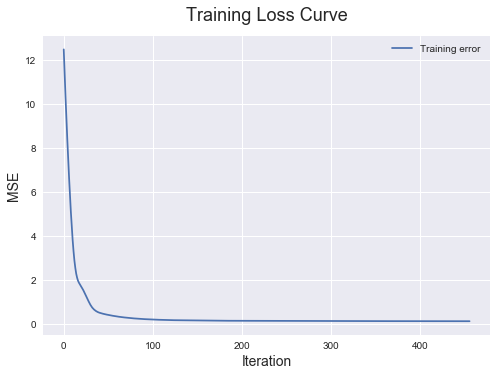

In [13]:
plt.style.use('seaborn')
plt.plot([i for i in range(mlpr_model.n_iter_)],
         mlpr_model.loss_curve_, label='Training error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.title('Training Loss Curve', fontsize=18, y=1.03)
plt.legend()


  ## MSE score with different training size and cross-validation method

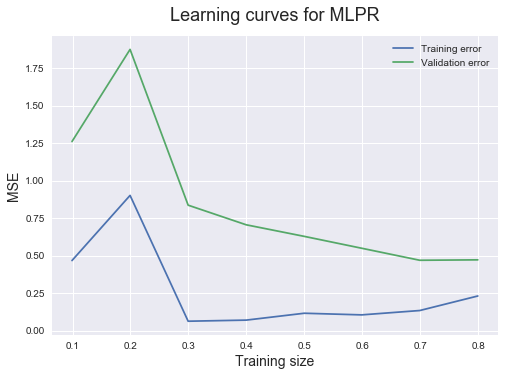

In [14]:

train_sizes = ((np.zeros((1, 8)) + x.shape[0]) * np.array(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])).astype(int)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=mlpr,
    X=x,
    y=y,
    train_sizes=train_sizes,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=0)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
plt.style.use('seaborn')
plt.plot(train_sizes / x.shape[0], train_scores_mean, label='Training error')
plt.plot(train_sizes / x.shape[0],
         validation_scores_mean, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training size', fontsize=14)
plt.title('Learning curves for MLPR', fontsize=18, y=1.03)
plt.legend()


  ## Comparison of predicted and actual target value (table)

In [15]:


def percentage_diff(predict, actual):
    if predict == actual or actual == 0 or predict == 0:
        return 0
    try:
        return round((abs(predict - actual) / actual) * 100.0, 3)
    except ZeroDivisionError:
        return 0


comparison = pd.concat(
    [pd.Series(np.array(y_test)), pd.Series(mlpr_predict)], axis=1, sort=False)
comparison[2] = np.absolute(comparison[0] - comparison[1])

percent = []
for i in range(0, comparison[0].size):
    percent.append(float(percentage_diff(comparison[1][i], comparison[0][i])))
comparison[3] = percent

comparison.rename(columns={0: 'Actual Rating', 1: 'Predicted Rating',
                           2: 'Difference', 3: '% Diff.'}, inplace=True)

comparison.sample(10)



,Actual Rating,Predicted Rating,Difference,% Diff.
96,6.5,6.774533,0.274533,4.224
219,7.8,7.455423,0.344577,4.418
83,6.4,6.873472,0.473472,7.398
169,7.2,7.568265,0.368265,5.115
22,5.6,6.049268,0.449268,8.023
31,5.9,5.886019,0.013981,0.237
61,6.3,6.599528,0.299528,4.754
66,6.3,7.188711,0.888711,14.107
162,7.2,6.532623,0.667377,9.269
196,7.5,7.806507,0.306507,4.087


In [16]:
print(f"Average diff. : {np.average(comparison['Difference'])}")
print(f"Average diff. percentage : {np.average(comparison['% Diff.'])}")


Average diff. : 0.373034869652587
Average diff. percentage : 6.391805555555555


  ## Comparison of predicted and actual target value (Curve Graph)
  * Red point : actual rating
  * Blue line : predicted rating

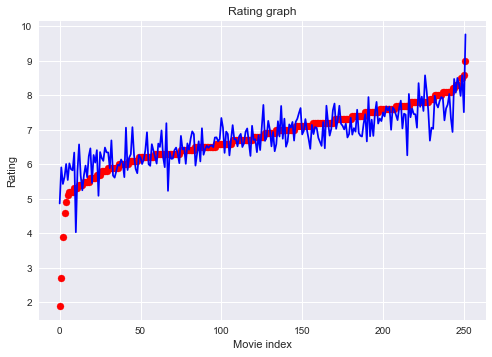

In [17]:
index_x = [i for i in range(0, y_test.size)]

plt.style.use('seaborn')
plt.scatter(index_x, y_test, color='red')
# plt.scatter(index_x, y_test, color='red')
plt.plot(index_x, mlpr_predict, color='blue')
# plt.scatter(index_x, mlpr_predict, color='blue')

plt.title('Rating graph')
plt.xlabel('Movie index')
plt.ylabel('Rating')

plt.show()
